# TripAdvisor

## Abstract

The purpose of this document is to explore the data provided after scraping TripAdvisor. The main reason to scrape this web is to extract data about restaurants and their reviews in Spain.

This document has two main sections: EDA and text classification. The first one tries to explain information hidden in data. The second one tries to classificate reviews in positive or negative depending on the text the user left.

** Version 2 Changelog: **
- Using describe function
- Data cleaning section with: % NaN and diversity by column
- [PENDING] Using loc instead of simple indexing -> Now, it raises an exception: [column] is not in [index]
- Measuring diferences between BoW and TF-IDF
- Avoiding output in charts
- Confusion matrix (normalized and not normalized) for both BoW and TF-IDF

## 1. EDA (Exploratory Data Analysis)

## 1.1. Load and check data

In [1]:
%matplotlib inline
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import itertools

In [2]:
restaurants = pd.read_json('restaurant.json', lines=True)
reviews = pd.read_json('review.json', lines=True)

restaurants.set_index('_id', inplace=True)
reviews.set_index('_id', inplace=True)

In [3]:
restaurants.head()

,address,cuisines,name,phone,price,ranking_position,rating,ratings,tags,updated_at
_id,,,,,,,,,,
d2006562,"{""locality"": ""28028 Madrid,"", ""street"": ""Calle...","[International, Mediterranean, European, Spani...",Los Montes de Galicia,+34 913 55 27 86,2.5,1,4.5,"[{""type"": ""Service"", ""value"": 4.5}, {""type"": ""...","[International, Mediterranean, European]",2018-05-23 09:12:01
d10428302,"{""locality"": ""28014 Madrid,"", ""street"": ""Carre...","[Mediterranean, European, Spanish, Contemporar...",Cebo,+34 917 87 77 80,4.0,2,5.0,"[{""type"": ""Service"", ""value"": 5}, {""type"": ""Fo...","[Mediterranean, European, Spanish]",2018-05-23 09:12:28
d13138415,"{""locality"": ""28001 Madrid,"", ""street"": ""Calle...","[Spanish, Mediterranean, Vegetarian Friendly, ...",Restaurante Etimo by Begona Fraire,+34 913 27 36 07,4.0,4,5.0,"[{""type"": ""Service"", ""value"": 5}, {""type"": ""Fo...","[Spanish, Mediterranean, Vegetarian Friendly]",2018-05-23 09:12:53
d11896546,"{""locality"": ""28005 Madrid,"", ""street"": ""Calle...","[International, Mediterranean, European, Fusio...",Astor,+34 910 39 80 00,2.5,3,5.0,"[{""type"": ""Service"", ""value"": 5}, {""type"": ""Fo...","[International, Mediterranean, European]",2018-05-23 09:12:41
d6884911,"{""locality"": ""28004 Madrid,"", ""street"": ""Calle...","[International, European, Spanish, Contemporar...",DSTAGE,+34 917 02 15 86,4.0,5,4.5,"[{""type"": ""Service"", ""value"": 5}, {""type"": ""Fo...","[International, European, Spanish]",2018-05-23 09:13:12


In [4]:
restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, d2006562 to d1990905
Data columns (total 10 columns):
address             13125 non-null object
cuisines            13125 non-null object
name                13125 non-null object
phone               13125 non-null object
price               13125 non-null float64
ranking_position    13125 non-null int64
rating              13125 non-null float64
ratings             13125 non-null object
tags                13125 non-null object
updated_at          13125 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 1.1+ MB


In [5]:
reviews.head()

,date,language,rating,restaurant_id,text,title,user,via_mobile
_id,,,,,,,,
review_579525119,{'$date': '2018-05-11T00:00:00.000Z'},es,5,d10428302,Cocina espectacular y trato exquisito. El loca...,Una experiencia única.,Daniel P,False
review_579955527,{'$date': '2018-05-13T00:00:00.000Z'},es,5,d10428302,De los mejores restaurantes en la actualidad d...,Comida aniversario,Ignacio D,False
review_579040389,{'$date': '2018-05-09T00:00:00.000Z'},en,5,d10428302,My wife and I had a reservation during a recen...,Just auperb,Joel A,True
review_579137239,{'$date': '2018-05-09T00:00:00.000Z'},ja,3,d10428302,ソルから歩いて１０分かかからない所にあり、立地としては便利です。ホテルの中にあります。お店の...,ミシュラン一つ星かぁ～うーん。,munnku,False
review_579018189,{'$date': '2018-05-09T00:00:00.000Z'},es,5,d10428302,"La decoración, la iluminación de las mesas (ho...",Excelencia hecha arte,Pedro E,False


In [6]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1362372 entries, review_579525119 to review_15458751
Data columns (total 8 columns):
date             1362372 non-null object
language         1362372 non-null object
rating           1362372 non-null int64
restaurant_id    1362372 non-null object
text             1362372 non-null object
title            1362372 non-null object
user             1362372 non-null object
via_mobile       1362372 non-null bool
dtypes: bool(1), int64(1), object(6)
memory usage: 84.5+ MB


In [7]:
restaurants.describe()

,price,ranking_position,rating
count,13125.000000,13125.000000,13125.000000
mean,0.951429,3187.121067,3.464114
std,1.684102,3005.221957,1.442212
min,-1.000000,-1.000000,-1.000000
25%,-1.000000,151.000000,3.000000
50%,1.000000,2543.000000,4.000000
75%,2.500000,5824.000000,4.500000
max,4.000000,9109.000000,5.000000


In [8]:
reviews.describe()

,rating
count,1.362372e+06
mean,4.080268e+00
std,1.140113e+00
min,1.000000e+00
25%,4.000000e+00
50%,4.000000e+00
75%,5.000000e+00
max,5.000000e+00


## 1.2. Data Cleaning

In [9]:
def non_na_percentage(df):
    return (100*df[df.columns].count() \
                 / len(df[df.columns])).sort_values()

def replace_value_to_nan(df):
    for column in df.columns:
        df[column] = df[column].apply(lambda x: None if x == -1 else x)
        
def diversity_percentage(df, columns):
    """
    This function returns the number of different elements in each column as a percentage of the total 
    elements in the group.
    A low value indicates there are many repeated elements.
    Example 1: a value of 0 indicates all values are the same.
    Example 2: a value of 100 indicates all values are different.
    """
    diversity = dict()
    
    for col in columns:
        diversity[col] = len(df[col].unique())
        
    diversity_series = pd.Series(diversity)
    return (100*diversity_series/len(df)).sort_values()

In [10]:
non_na_percentage(restaurants)

address             100.0
cuisines            100.0
name                100.0
phone               100.0
price               100.0
ranking_position    100.0
rating              100.0
ratings             100.0
tags                100.0
updated_at          100.0
dtype: float64

In [11]:
non_na_percentage(reviews)

date             100.0
language         100.0
rating           100.0
restaurant_id    100.0
text             100.0
title            100.0
user             100.0
via_mobile       100.0
dtype: float64

It seems that all columns have values but this is not true. Some columns have -1 as value whose meaning is NaN. So, let's replace -1 to NaN.

In [12]:
replace_value_to_nan(restaurants)

In [13]:
replace_value_to_nan(reviews)

In [14]:
non_na_percentage(restaurants)

price                60.708571
ranking_position     92.739048
rating               92.792381
address             100.000000
cuisines            100.000000
name                100.000000
phone               100.000000
ratings             100.000000
tags                100.000000
updated_at          100.000000
dtype: float64

This has more sense. A lot of restaurants have not got price, ranking_position and/or rating

In [15]:
non_na_percentage(reviews)

date             100.0
language         100.0
rating           100.0
restaurant_id    100.0
text             100.0
title            100.0
user             100.0
via_mobile       100.0
dtype: float64

In [16]:
diversity_percentage(restaurants, ['price', 'rating'])

price     0.030476
rating    0.076190
dtype: float64

In [17]:
diversity_percentage(reviews, ['language', 'rating'])

rating      0.000367
language    0.003083
dtype: float64

As we can see, the result is really close to 0. This means that is a categorical variable

## 1.3. Feature Engineering

If you look at previous data, there are some columns that need to be cleaned:

- Restaurant:
    - Address: It's a string with JSON format and multiple data
    - Ratings: It's a string with JSON format and multiple data
- Review:
    - Date: It's a string with JSON format

In [18]:
# Splitting column address into street, locality and country
restaurants['street'] = restaurants['address'].apply(lambda x: json.loads(x)['street'])
restaurants['locality'] = restaurants['address'].apply(lambda x: json.loads(x)['locality'].replace(",", ""))
restaurants['country'] = restaurants['address'].apply(lambda x: json.loads(x)['country'])
del restaurants['address']

In [19]:
restaurants['reviews'] = [reviews[reviews['restaurant_id'] == index]['restaurant_id'].count() for index, restaurant in restaurants.iterrows()]

In [20]:
# Splitting locality that contains postal code and locality in two columns
restaurants['postal code'], restaurants['locality'] = restaurants['locality'].str.split(' ', 1).str

In [21]:
# The ratings sometimes have the address so let's fix it.
# First of all, we should check which categories we have in rating
rating_types = []
def get_rating_types(ratings):
    ratings = json.loads(ratings)
    for rating in ratings:
        rating_type = rating["type"]
        if rating["value"] != -1 and rating_type not in rating_types:
            rating_types.append(rating_type)            

restaurants['ratings'].apply(lambda x: get_rating_types(x))

def get_rating_values(rating_type, ratings):
    ratings = json.loads(ratings)
    for rating in ratings:
        rating_value = rating["value"]
        if rating_type == rating["type"] and rating_value != -1:
            return rating_value
    return None

# For every category in ratings, we are creating a new column
for rating_type in rating_types:
    restaurants[rating_type.lower() + ' rating'] = restaurants['ratings'].apply(lambda x: get_rating_values(rating_type, x))

del restaurants['ratings']

In [22]:
# Converting date column to datetime format
reviews['date'] = reviews['date'].apply(lambda x: x['$date'])
reviews['date'] = pd.to_datetime(reviews['date'], format='%Y-%m-%dT%H:%M:%S.%f')

In [23]:
reviews['text length'] = reviews['text'].apply(len)

In [24]:
restaurants.head()

,cuisines,name,phone,price,ranking_position,rating,tags,updated_at,street,locality,country,reviews,postal code,service rating,food rating,value rating,atmosphere rating
_id,,,,,,,,,,,,,,,,,
d2006562,"[International, Mediterranean, European, Spani...",Los Montes de Galicia,+34 913 55 27 86,2.5,1.0,4.5,"[International, Mediterranean, European]",2018-05-23 09:12:01,Calle Azcona 46,Madrid,Spain,4474,28028,4.5,4.5,4.5,4.5
d10428302,"[Mediterranean, European, Spanish, Contemporar...",Cebo,+34 917 87 77 80,4.0,2.0,5.0,"[Mediterranean, European, Spanish]",2018-05-23 09:12:28,Carrera San Jeronimo 34,Madrid,Spain,536,28014,5.0,4.5,4.5,NaN
d13138415,"[Spanish, Mediterranean, Vegetarian Friendly, ...",Restaurante Etimo by Begona Fraire,+34 913 27 36 07,4.0,4.0,5.0,"[Spanish, Mediterranean, Vegetarian Friendly]",2018-05-23 09:12:53,Calle Ayala 27,Madrid,Spain,219,28001,5.0,5.0,4.5,NaN
d11896546,"[International, Mediterranean, European, Fusio...",Astor,+34 910 39 80 00,2.5,3.0,5.0,"[International, Mediterranean, European]",2018-05-23 09:12:41,Calle del Almendro 9,Madrid,Spain,461,28005,5.0,5.0,4.5,NaN
d6884911,"[International, European, Spanish, Contemporar...",DSTAGE,+34 917 02 15 86,4.0,5.0,4.5,"[International, European, Spanish]",2018-05-23 09:13:12,"Calle de Regueros, 8",Madrid,Spain,1833,28004,5.0,5.0,4.5,4.5


In [25]:
reviews.head()

,date,language,rating,restaurant_id,text,title,user,via_mobile,text length
_id,,,,,,,,,
review_579525119,2018-05-11,es,5,d10428302,Cocina espectacular y trato exquisito. El loca...,Una experiencia única.,Daniel P,False,110
review_579955527,2018-05-13,es,5,d10428302,De los mejores restaurantes en la actualidad d...,Comida aniversario,Ignacio D,False,318
review_579040389,2018-05-09,en,5,d10428302,My wife and I had a reservation during a recen...,Just auperb,Joel A,True,507
review_579137239,2018-05-09,ja,3,d10428302,ソルから歩いて１０分かかからない所にあり、立地としては便利です。ホテルの中にあります。お店の...,ミシュラン一つ星かぁ～うーん。,munnku,False,239
review_579018189,2018-05-09,es,5,d10428302,"La decoración, la iluminación de las mesas (ho...",Excelencia hecha arte,Pedro E,False,175


In [26]:
non_na_percentage(restaurants)

atmosphere rating     42.895238
price                 60.708571
food rating           84.365714
value rating          84.502857
service rating        84.655238
ranking_position      92.739048
rating                92.792381
locality              96.312381
postal code          100.000000
reviews              100.000000
cuisines             100.000000
updated_at           100.000000
tags                 100.000000
phone                100.000000
name                 100.000000
country              100.000000
street               100.000000
dtype: float64

In [27]:
non_na_percentage(reviews)

date             100.0
language         100.0
rating           100.0
restaurant_id    100.0
text             100.0
title            100.0
user             100.0
via_mobile       100.0
text length      100.0
dtype: float64

Now, we have two dataframes with better data structure

## 1.4. Data Analysis

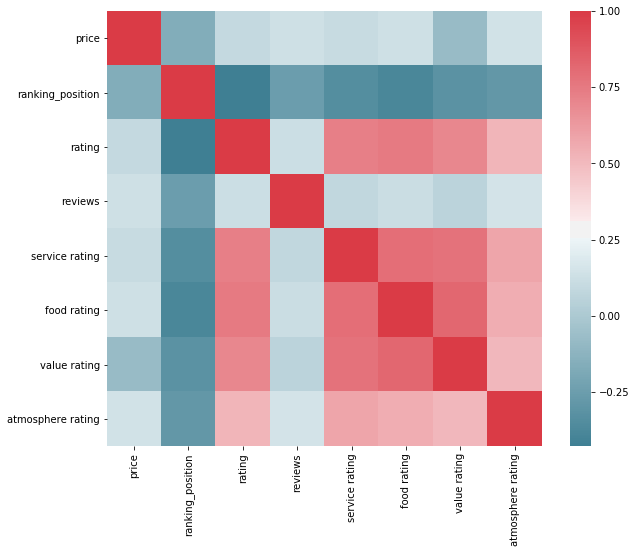

In [28]:
f, ax = plt.subplots(figsize=(10, 8))
corr = restaurants.corr()
_ = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

As you can see, the correlation matrix does not contribute a lot to clarify the relationships between variables. However, there's a strong correlation between rating variables.

### 1.4.1. Language

Spain is a country that many people like to visit. The sun, the food... There are many reasons to visit Spain. So, I guess that many reviews are written in foreign languages

In [29]:
df_languages = pd.read_csv('language_codes.csv')

In [30]:
reviews['language'] = reviews['language'].replace('zh-cn', 'zh').replace('zh-tw', 'zh')

I have replaced simplified chinese and Taiwan chinese with just chinese because the dataset with all languages only include this language

In [31]:
reviews['language'].value_counts().rename(lambda x: df_languages[df_languages['alpha2'] == x]['English'])

[Spanish; Castilian]               877998
[English]                          261224
[Italian]                           80575
[French]                            53058
[Portuguese]                        28788
[German]                            15223
[Russian]                           11086
[Dutch; Flemish]                    10686
[Swedish]                            3902
[Japanese]                           3619
[Danish]                             2895
[Korean]                             2683
[Norwegian]                          2329
[Chinese]                            2280
[Polish]                             1268
[Turkish]                            1215
[Hebrew]                             1099
[Greek, Modern (1453-)]               730
[Hungarian]                           484
[Finnish]                             376
[Arabic]                              182
[Catalan; Valencian]                  159
[Czech]                               141
[Afrikaans]                       

The top language is spanish as I expected. The following top languages are english, italian, french and portuguese.

### 1.4.2. Rating

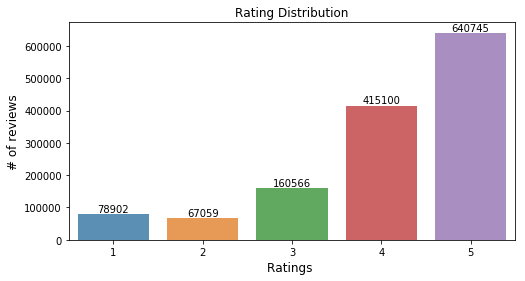

In [32]:
x = reviews['rating'].value_counts()
x = x.sort_index()

plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Rating Distribution")
plt.ylabel('# of reviews', fontsize=12)
plt.xlabel('Ratings ', fontsize=12)

rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

It seems that people are happy with the restaurants they visit. There are a lot of 5-4 stars reviews!

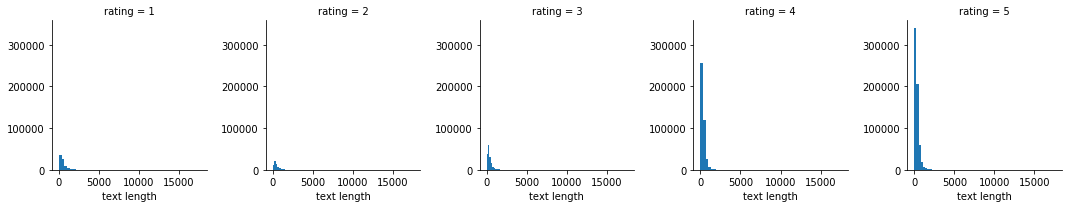

In [33]:
g = sns.FacetGrid(data=reviews, col='rating')
g.map(plt.hist, 'text length', bins=50)

In [34]:
for i in range(1,6):
    print('The median characters with {} stars: {}'.format(i, int(np.median(reviews[reviews['rating'] == i]['text length']))))
    print('The mean characters with {} stars: {}'.format(i, int(np.mean(reviews[reviews['rating'] == i]['text length']))))

The median characters with 1 stars: 393
The mean characters with 1 stars: 524
The median characters with 2 stars: 388
The mean characters with 2 stars: 505
The median characters with 3 stars: 307
The mean characters with 3 stars: 405
The median characters with 4 stars: 267
The mean characters with 4 stars: 345
The median characters with 5 stars: 259
The mean characters with 5 stars: 339


People furious with the restaurant (1-2 stars) spend more time (almost twice) writing a review than people who love the place

In [35]:
spanish_mean_rating = np.mean(reviews[reviews['language'] == 'es']['rating'])
english_mean_rating = np.mean(reviews[reviews['language'] == 'en']['rating'])
italian_mean_rating = np.mean(reviews[reviews['language'] == 'it']['rating'])
frech_mean_rating = np.mean(reviews[reviews['language'] == 'fr']['rating'])
portuguese_mean_rating = np.mean(reviews[reviews['language'] == 'pt']['rating'])

print('Spanish rating (mean): {0:.2f}'.format(spanish_mean_rating))
print('English rating (mean): {0:.2f}'.format(english_mean_rating))
print('Italian rating (mean): {0:.2f}'.format(italian_mean_rating))
print('Frech rating (mean): {0:.2f}'.format(frech_mean_rating))
print('Portuguese rating (mean): {0:.2f}'.format(portuguese_mean_rating))

Spanish rating (mean): 3.95
English rating (mean): 4.37
Italian rating (mean): 4.17
Frech rating (mean): 4.29
Portuguese rating (mean): 4.31


### 1.4.3. Cuisines

In [36]:
popular_restaurants = restaurants.sort_values(by='reviews', ascending=False).head(20)

In [37]:
def count_list_ocurrences(element_list, elements_dict):
    for element in element_list:
        if element in elements_dict:
            elements_dict[element] += 1
        else:
            elements_dict[element] = 1

In [38]:
cuisines_dict = {}
for cuisines in popular_restaurants['cuisines']:
    count_list_ocurrences(cuisines, cuisines_dict)

popular_cuisines = sorted(cuisines_dict.items(), key = operator.itemgetter(1), reverse=True)
popular_cuisines

[('Spanish', 17),
 ('Gluten Free Options', 17),
 ('Mediterranean', 16),
 ('Vegetarian Friendly', 15),
 ('Vegan Options', 15),
 ('European', 12),
 ('International', 3),
 ('Fusion', 3),
 ('Seafood', 2),
 ('Soups', 2),
 ('Japanese', 2),
 ('Asian', 2),
 ('Contemporary', 2),
 ('Sushi', 1),
 ('Bar', 1),
 ('Peruvian', 1),
 ('Italian', 1)]

Spanish, gluten free options, mediterranean, vegetarian friendly, vengan options and european food are really popular in Spain.

In [39]:
expensive_restaurants = restaurants.sort_values(by=['price'], ascending=False).head(20)

In [40]:
cuisines_exp_dict = {}
for cuisines in expensive_restaurants['cuisines']:
    count_list_ocurrences(cuisines, cuisines_exp_dict)

popular_exp_cuisines = sorted(cuisines_exp_dict.items(), key = operator.itemgetter(1), reverse=True)
popular_exp_cuisines

[('Mediterranean', 14),
 ('Spanish', 12),
 ('European', 10),
 ('Gluten Free Options', 10),
 ('Vegetarian Friendly', 9),
 ('Vegan Options', 8),
 ('Fusion', 3),
 ('International', 2),
 ('Japanese', 2),
 ('Contemporary', 2),
 ('Colombian', 1),
 ('Mexican', 1),
 ('Latin', 1),
 ('Sushi', 1),
 ('Asian', 1),
 ('Deli', 1),
 ('Italian', 1),
 ('Russian', 1)]

If we sort by price, we get the same results than just sorting by reviews with one exception: vengan options.

### 1.4.4. Via mobile

In [41]:
reviews['via_mobile'].value_counts()

False    698043
True     664329
Name: via_mobile, dtype: int64

In [42]:
via_mobile_true_mean_rating = np.mean(reviews[reviews['via_mobile'] == True]['rating'])
via_mobile_false_mean_rating = np.mean(reviews[reviews['via_mobile'] == False]['rating'])
print('Via mobile rating (mean): {0:.2f}'.format(via_mobile_true_mean_rating))
print('No via mobile rating (mean): {0:.2f}'.format(via_mobile_false_mean_rating))

Via mobile rating (mean): 4.09
No via mobile rating (mean): 4.07


People that review a restaurant from a mobile device rate with the same stars than people who do it from a computer.

## 2. Text Classification

In [43]:
import nltk
import string
import numpy as np
import pandas as pd
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.manifold import TSNE

In [44]:
top_reviews_es = reviews[(reviews['rating'] >= 4) & (reviews['language'] == 'es')]
poor_reviews_es = reviews[(reviews['rating'] <= 2) & (reviews['language'] == 'es')]
polarized_reviews = pd.concat([top_reviews_es, poor_reviews_es])

In [45]:
X = polarized_reviews['text']
y = polarized_reviews['rating'].apply(lambda x: 1 if x >= 4 else 0)

In [46]:
def clean_text(text):
    
    ## Remove puncuation
    text = text.translate(string.punctuation)
    
    ## Convert words to lower case and split them
    text = text.lower().split()
    
    ## Remove stop words
    stops = set(stopwords.words("spanish"))
    text = [w for w in text if not w in stops and len(w) >= 3]
    
    text = " ".join(text)
    
    ## Clean text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    ## Stemming
    text = text.split()
    stemmer = SnowballStemmer('spanish')
    stemmed_words = [stemmer.stem(word) for word in text]
    return stemmed_words

In [47]:
%%time
bow_transformer = CountVectorizer(analyzer=clean_text).fit(X)
X_bow = bow_transformer.transform(X)

CPU times: user 24min 40s, sys: 29 s, total: 25min 9s
Wall time: 49min 8s


In [48]:
%%time
tf_transformer = TfidfVectorizer(analyzer=clean_text).fit(X)
X_tf = tf_transformer.transform(X)

CPU times: user 24min 51s, sys: 29.7 s, total: 25min 20s
Wall time: 25min 23s


In [49]:
X_bow_train, X_bow_test, y_bow_train, y_bow_test = train_test_split(X_bow, y, test_size=0.3, random_state=101)

In [50]:
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y, test_size=0.3, random_state=101)

In [51]:
nb_bow = MultinomialNB()
nb_bow.fit(X_bow_train, y_bow_train)
preds_bow = nb_bow.predict(X_bow_test)
print(classification_report(y_bow_test, preds_bow))

             precision    recall  f1-score   support

          0       0.84      0.87      0.85     34239
          1       0.98      0.97      0.97    193043

avg / total       0.96      0.96      0.96    227282



In [52]:
nb_tf = MultinomialNB()
nb_tf.fit(X_tf_train, y_tf_train)
preds_tf = nb_tf.predict(X_tf_test)
print(classification_report(y_tf_test, preds_tf))

             precision    recall  f1-score   support

          0       0.97      0.47      0.64     34239
          1       0.91      1.00      0.95    193043

avg / total       0.92      0.92      0.91    227282



In [53]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [54]:
cnf_bow_matrix = confusion_matrix(y_bow_test, preds_bow)

In [55]:
cnf_tf_matrix = confusion_matrix(y_tf_test, preds_tf)

Normalized confusion matrix
[[ 0.86737346  0.13262654]
 [ 0.0290298   0.9709702 ]]


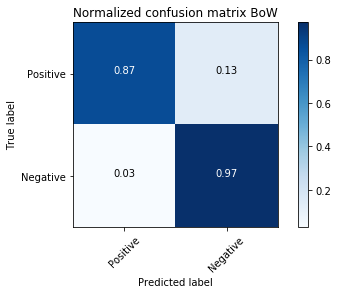

In [56]:
plot_confusion_matrix(cnf_bow_matrix, classes=['Negative','Positive'], normalize=True,
                      title='Normalized confusion matrix BoW')

Confusion matrix, without normalization
[[ 29698   4541]
 [  5604 187439]]


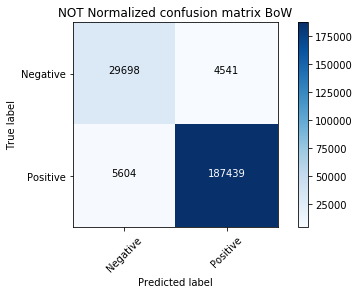

In [65]:
plot_confusion_matrix(cnf_bow_matrix, classes=['Negative','Positive'], normalize=False,
                      title='NOT Normalized confusion matrix BoW')

Normalized confusion matrix
[[ 0.86737346  0.13262654]
 [ 0.0290298   0.9709702 ]]


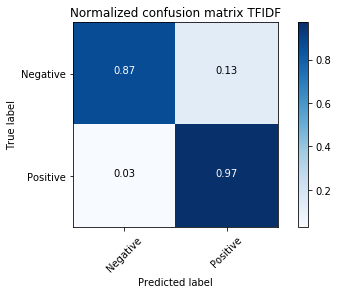

In [66]:
plot_confusion_matrix(cnf_bow_matrix, classes=['Negative','Positive'], normalize=True,
                      title='Normalized confusion matrix TFIDF')

Confusion matrix, without normalization
[[ 29698   4541]
 [  5604 187439]]


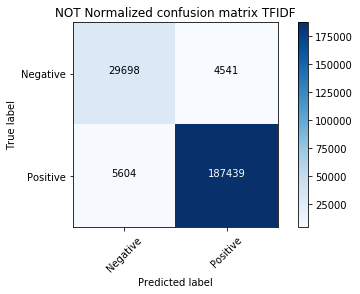

In [63]:
plot_confusion_matrix(cnf_bow_matrix, classes=['Negative','Positive'], normalize=False,
                      title='NOT Normalized confusion matrix TFIDF')

In [60]:
negative_review_transformed = bow_transformer.transform(['La carne estaba muy hecha y el camarero nos atendió con desprecio'])
nb_bow.predict(negative_review_transformed)[0]

0

In [61]:
positive_review_transformed = bow_transformer.transform(['Nos gustó mucho el sitio. Recomendable la pizza barbacoa'])
nb_bow.predict(positive_review_transformed)[0]

1